Solution Scope

Provide one page summary to support investment decision on packages/groups of products needing repairment.

A manufacturing company has inventoried few of its products under off-grade classification given details about defects and repair cost for 100 different products  with one o several of 1000 defects type. 

Using an unsupervised machine learning model this solution offers an investment decision support matrix which based on defect types find defect similarities and grouped into investment packages.

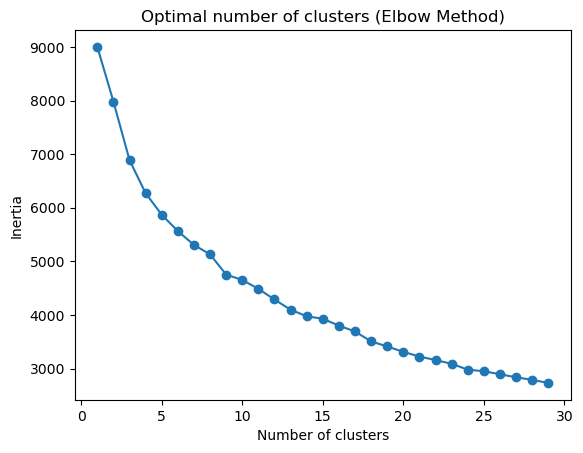

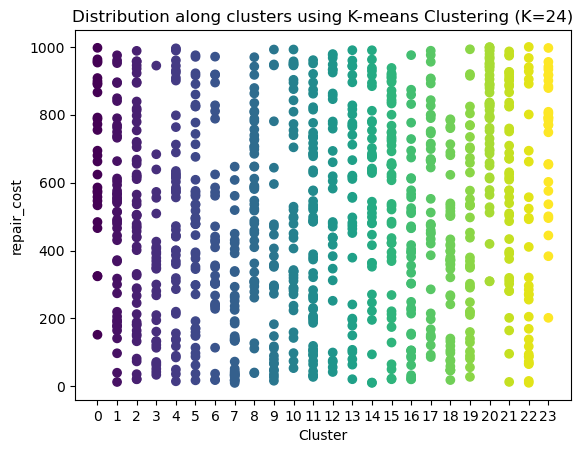


Investment Decision Support Matrix:



,min,max,mean,count,sum
cluster,,,,,
20,309,999,794,51,"40,501"
15,21,938,585,51,"29,860"
2,21,988,508,57,"28,965"
21,13,987,613,45,"27,589"
8,39,969,558,47,"26,203"
11,28,961,449,58,"26,019"
17,86,988,562,44,"24,732"
4,15,995,509,48,"24,446"
1,13,975,507,48,"24,360"


In [5]:
# Importing required packages
import os
os.environ["OMP_NUM_THREADS"] = '1'
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Loading the dataset
# original dataset @ https://www.kaggle.com/datasets/fahmidachowdhury/manufacturing-defects
defects_df = pd.read_csv("defects_data.csv")

# Preprocessing dataset to convert categorical variables into dummy/indicator variables
categorical_features = ['defect_type', 'defect_location', 'severity', 'inspection_method']
df_dummies = pd.get_dummies(defects_df[categorical_features], drop_first=True)
numerical_features = ['repair_cost']             # This was determined as the key feature in focus 
df_numerical = defects_df[numerical_features]
df_final = pd.concat([df_numerical, df_dummies], axis=1)

# Preprocessing dataset: standarizing/scaling
scaler = StandardScaler()
X = scaler.fit_transform(df_final)
defects_preprocessed = pd.DataFrame(data=X,columns=df_final.columns)

# Finding the optimal number of clusters for k-means clustering on scaled data
inertia = []
for k in range(1, 30):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(defects_preprocessed)
    inertia.append(kmeans.inertia_)    
plt.plot(range(1, 30), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Optimal number of clusters (Elbow Method)')
plt.show()


# Running the k-means clustering algorithm with the optimal number of clusters
# on scaled data and assigning clusters label output on data with numerical/dummies
n_clusters=24
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(defects_preprocessed)
df_final['cluster'] = kmeans.labels_


# Visualizing clusters on feature in concern ('repair_cost')
# to validate balanced distribution along clusters
plt.scatter(df_final['cluster'], df_final['repair_cost'], c=kmeans.labels_, cmap='viridis')
plt.xlabel('Cluster')
plt.ylabel('repair_cost')
plt.xticks(range(int(df_final['cluster'].min()), int(df_final['cluster'].max()) + 1))
plt.title(f'Distribution along clusters using K-means Clustering (K={n_clusters})')
plt.show()

# Creating investment decision support matrix
print('\nInvestment Decision Support Matrix:\n')
sm_defects = df_final.groupby('cluster')['repair_cost'].agg(['min', 'max', 'mean', 'count','sum'])
sm_defects.sort_values(by='sum', ascending=False).style.format("{:,.0f}")
